# Bank Marketing Data - A Decision Tree Approach

## Aim:`

The aim of this attempt is to predict if the client will subscribe (yes/no) to a term deposit, by building a classification model using Decision Tree.
Supporting Paper : http://media.salford-systems.com/video/tutorial/2015/targeted_marketing.pdf

In [1]:
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
from sklearn.cluster import KMeans
from sklearn import datasets

from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics

In [3]:
# data 
bank=pd.read_csv('../data/bank.csv')
bank.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

In [6]:
bank.values.shape

(11162, 17)

## Summay of data

### Categorical Variables :
**[1] job      :** admin,technician, services, management, retired, blue-collar, unemployed, entrepreneur,
               housemaid, unknown, self-employed, student
<br>**[2] marital  :** married, single, divorced
<br>**[3] education:** secondary, tertiary, primary, unknown
<br>**[4] default  :** yes, no
<br>**[5] housing  :** yes, no
<br>**[6] loan     :** yes, no 
<br>**[7] deposit  :** yes, no ** (Dependent Variable)**
<br>**[8] contact  :** unknown, cellular, telephone
<br>**[9] month    :** jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec
<br>**[10] poutcome:** unknown, other, failure, success

### Numerical Variables:
**[1] age 
<br>[2] balance
<br>[3] day
<br>[4] duration
<br>[5] campaign
<br>[6] pdays
<br>[7] previous **

In [7]:
# Check if the data set contains any null values - Nothing found!
bank[bank.isnull().any(axis=1)].count()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

Quick overview of the data in the dataframe <b> bank </b>

In [32]:
bank.describe()

age       balance           day      duration      campaign  \
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000   
mean      41.231948   1528.538524     15.658036    371.993818      2.508421   
std       11.913369   3225.413326      8.420740    347.128386      2.722077   
min       18.000000  -6847.000000      1.000000      2.000000      1.000000   
25%       32.000000    122.000000      8.000000    138.000000      1.000000   
50%       39.000000    550.000000     15.000000    255.000000      2.000000   
75%       49.000000   1708.000000     22.000000    496.000000      3.000000   
max       95.000000  81204.000000     31.000000   3881.000000     63.000000   

              pdays      previous  
count  11162.000000  11162.000000  
mean      51.330407      0.832557  
std      108.758282      2.292007  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       20.750000      1.000000  
max      854.000000     58.000000

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


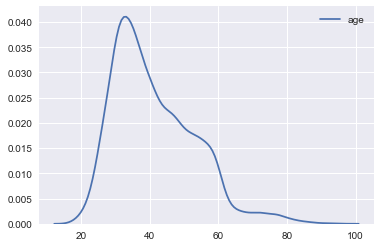

In [9]:
# Distribution of Age
sns.kdeplot(bank.age);


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


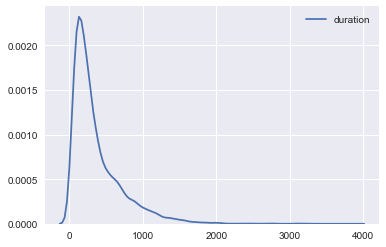

In [34]:
sns.kdeplot(bank.duration);

<h3>Reducing number of job categories</h3>

In [10]:
# Make a copy for parsing
bank_data = bank.copy()
print('Nbr of Jobs categories:',len(bank_data['job'].unique()))
print(bank_data['job'].unique())

Nbr of Jobs categories: 12
['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']


In [11]:
# Combine similar jobs into categories
bank_data['job'] = bank_data['job'].replace(['management', 'admin.'], 'white-collar')
bank_data['job'] = bank_data['job'].replace(['services','housemaid'], 'pink-collar')
bank_data['job'] = bank_data['job'].replace(['retired', 'student', 'unemployed', 'unknown'], 'other')

In [12]:
# New value counts
print('Nbr of Jobs categories:',len(bank_data['job'].unique()))
bank_data['job'].unique()

Nbr of Jobs categories: 7


array(['white-collar', 'technician', 'pink-collar', 'other',
       'blue-collar', 'entrepreneur', 'self-employed'], dtype=object)

<h3>Reduce poutome </h3>

In [38]:
bank_data.poutcome.value_counts()

unknown    8326
failure    1228
success    1071
other       537
Name: poutcome, dtype: int64

In [13]:
# Combine 'unknown' and 'other' as 'other' isn't really match with either 'success' or 'failure'
bank_data['poutcome'] = bank_data['poutcome'].replace(['other'] , 'unknown')
bank_data.poutcome.value_counts()

unknown    8863
failure    1228
success    1071
Name: poutcome, dtype: int64

<h3>Removed contact </h3>

In [14]:
# Drop 'contact', as every participant has been contacted. 
bank_data.drop('contact', axis=1, inplace=True)

<h3>Changes some variables into Boolean 0/1</h3>

In [15]:
# values for "default" : yes/no
bank_data['default_cat'] = bank_data['default'].map( {'yes':1, 'no':0} )
bank_data.drop('default', axis=1,inplace = True)

In [16]:
# values for "housing" : yes/no
bank_data["housing_cat"]=bank_data['housing'].map({'yes':1, 'no':0})
bank_data.drop('housing', axis=1,inplace = True)

In [17]:
# values for "loan" : yes/no
bank_data["loan_cat"] = bank_data['loan'].map({'yes':1, 'no':0})
bank_data.drop('loan', axis=1, inplace=True)

In [18]:
# values for "deposit" : yes/no
bank_data["deposit_cat"] = bank_data['deposit'].map({'yes':1, 'no':0})
bank_data.drop('deposit', axis=1, inplace=True)

<h3>Remove the date </h3>

In [19]:
# day  : last contact day of the month
# month: last contact month of year
# Drop 'month' and 'day' as they don't have any intrinsic meaning
bank_data.drop('month', axis=1, inplace=True)
bank_data.drop('day', axis=1, inplace=True)

<h3>Remap pdays variable </h3>

In [20]:
# pdays: number of days that passed by after the client was last contacted from a previous campaign
#       -1 means client was not previously contacted

print("Customers that have not been contacted before:", len(bank_data[bank_data.pdays==-1]))
print("Maximum values on padys    :", bank_data['pdays'].max())

Customers that have not been contacted before: 8324
Maximum values on padys    : 854


In [21]:
# Map padys=-1 into a large value (10000 is used) to indicate that it is so far in the past that it has no effect
bank_data.loc[bank_data['pdays'] == -1, 'pdays'] = 10000

In [22]:
# Create a new column: recent_pdays 
bank_data['recent_pdays'] = bank_data['pdays'].apply(lambda x : 1/x)
# Drop 'pdays'
bank_data.drop('pdays', axis=1, inplace = True)

In [23]:
bank_data.tail()

age          job  marital  education  balance  duration  campaign  \
11157   33  blue-collar   single    primary        1       257         1   
11158   39  pink-collar  married  secondary      733        83         4   
11159   32   technician   single  secondary       29       156         2   
11160   43   technician  married  secondary        0         9         2   
11161   34   technician  married  secondary        0       628         1   

       previous poutcome  default_cat  housing_cat  loan_cat  deposit_cat  \
11157         0  unknown            0            1         0            0   
11158         0  unknown            0            0         0            0   
11159         0  unknown            0            0         0            0   
11160         5  failure            0            0         1            0   
11161         0  unknown            0            0         0            0   

       recent_pdays  
11157      0.000100  
11158      0.000100  
11159      0.000100  
11160      0.005814  
11161      0.000100

<h3> The categorical variables job,marital,eduction,poutomce are replaced by dummy variables</h3>
<ul>
<li>Job : 7 categories=>7-1=6 dummy variables
<li>Marital: 3 categories=>3-1=2 dummy variables
<li>Education:4=>4-1=3 dummy varaibles
<li>poutcome:3=> 3-1=2 dummy variables
</ul>

In [24]:
# Convert categorical variables to dummies
bank_with_dummies = pd.get_dummies(data=bank_data, columns = ['job', 'marital', 'education', 'poutcome'], \
                                   prefix = ['job', 'marital', 'education', 'poutcome'])
bank_with_dummies.head()

age  balance  duration  campaign  previous  default_cat  housing_cat  \
0   59     2343      1042         1         0            0            1   
1   56       45      1467         1         0            0            0   
2   41     1270      1389         1         0            0            1   
3   55     2476       579         1         0            0            1   
4   54      184       673         2         0            0            0   

   loan_cat  deposit_cat  recent_pdays        ...         marital_divorced  \
0         0            1        0.0001        ...                        0   
1         0            1        0.0001        ...                        0   
2         0            1        0.0001        ...                        0   
3         0            1        0.0001        ...                        0   
4         0            1        0.0001        ...                        0   

   marital_married  marital_single  education_primary  education_secondary  \
0                1               0                  0                    1   
1                1               0                  0                    1   
2                1               0                  0                    1   
3                1               0                  0                    1   
4                1               0                  0                    0   

   education_tertiary  education_unknown  poutcome_failure  poutcome_success  \
0                   0                  0                 0                 0   
1                   0                  0                 0                 0   
2                   0                  0                 0                 0   
3                   0                  0                 0                 0   
4                   1                  0                 0                 0   

   poutcome_unknown  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  

[5 rows x 27 columns]

In [26]:
print('Data set before:',bank_data.shape)
print('Data after adding dummy variables:',bank_with_dummies.shape)

Data set before: (11162, 14)
Data after adding dummy variables: (11162, 27)


In [27]:
bank_with_dummies.describe()

age       balance      duration      campaign      previous  \
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000   
mean      41.231948   1528.538524    371.993818      2.508421      0.832557   
std       11.913369   3225.413326    347.128386      2.722077      2.292007   
min       18.000000  -6847.000000      2.000000      1.000000      0.000000   
25%       32.000000    122.000000    138.000000      1.000000      0.000000   
50%       39.000000    550.000000    255.000000      2.000000      0.000000   
75%       49.000000   1708.000000    496.000000      3.000000      1.000000   
max       95.000000  81204.000000   3881.000000     63.000000     58.000000   

        default_cat   housing_cat      loan_cat   deposit_cat  recent_pdays  \
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000   
mean       0.015051      0.473123      0.130801      0.473840      0.003124   
std        0.121761      0.499299      0.337198      0.499338      0.030686   
min        0.000000      0.000000      0.000000      0.000000      0.000100   
25%        0.000000      0.000000      0.000000      0.000000      0.000100   
50%        0.000000      0.000000      0.000000      0.000000      0.000100   
75%        0.000000      1.000000      0.000000      1.000000      0.001919   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

             ...         marital_divorced  marital_married  marital_single  \
count        ...             11162.000000     11162.000000    11162.000000   
mean         ...                 0.115839         0.568984        0.315176   
std          ...                 0.320047         0.495241        0.464607   
min          ...                 0.000000         0.000000        0.000000   
25%          ...                 0.000000         0.000000        0.000000   
50%          ...                 0.000000         1.000000        0.000000   
75%          ...                 0.000000         1.000000        1.000000   
max          ...                 1.000000         1.000000        1.000000   

       education_primary  education_secondary  education_tertiary  \
count       11162.000000         11162.000000        11162.000000   
mean            0.134385             0.490593            0.330496   
std             0.341080             0.499934            0.470413   
min             0.000000             0.000000            0.000000   
25%             0.000000             0.000000            0.000000   
50%             0.000000             0.000000            0.000000   
75%             0.000000             1.000000            1.000000   
max             1.000000             1.000000            1.000000   

       education_unknown  poutcome_failure  poutcome_success  poutcome_unknown  
count       11162.000000      11162.000000      11162.000000      11162.000000  
mean            0.044526          0.110016          0.095951          0.794033  
std             0.206270          0.312924          0.294537          0.404424  
min             0.000000          0.000000          0.000000          0.000000  
25%             0.000000          0.000000          0.000000          1.000000  
50%             0.000000          0.000000          0.000000          1.000000  
75%             0.000000          0.000000          0.000000          1.000000  
max             1.000000          1.000000          1.000000          1.000000  

[8 rows x 27 columns]

<h3>Build the Data Model</h3>

In [28]:
# make a copy
bankcl = bank_with_dummies.copy()

In [29]:
# Train-Test split: 20% test data
X = bankcl.drop('deposit_cat', 1)
Y = bankcl.deposit_cat
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size = 0.2,
                                                    random_state = 50)



In [30]:
# Decision tree with depth = 4
dt4 = tree.DecisionTreeClassifier(random_state=1, max_depth=4)

In [31]:
type(dt4)

sklearn.tree.tree.DecisionTreeClassifier

In [32]:
dt4.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [33]:
dt4_score_train = dt4.score(X_train, Y_train)

In [34]:
print("Training score: ",dt4_score_train)
dt4_score_test = dt4.score(X_test, Y_test)
print("Testing score: ",dt4_score_test)

Training score:  0.7885541494008288
Testing score:  0.774294670846395


In [35]:
# Decision tree: To the full depth
dt1 = tree.DecisionTreeClassifier()

In [37]:
dt1.fit(X_train, Y_train)
dt1_score_train = dt1.score(X_train, Y_train)
print("Training score: ", dt1_score_train)
dt1_score_test = dt1.score(X_test, Y_test)
print("Testing score: ", dt1_score_test)

Training score:  1.0
Testing score:  0.7375727720555306


In [38]:
# Investigate most important features with depth =2
features = X.columns
dt4 = tree.DecisionTreeClassifier(random_state=1, max_depth=4)

# Fit the decision tree classifier
dt4.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [39]:
fi = dt4.feature_importances_
print(fi)

[0.         0.00208648 0.66891851 0.         0.         0.
 0.10592941 0.         0.10371814 0.         0.         0.
 0.         0.         0.         0.         0.         0.00186513
 0.         0.         0.         0.         0.         0.
 0.11748234 0.        ]


In [40]:
df = pd.DataFrame({'feature':features,'importance':fi})

In [41]:
df.sort_values(by='importance',ascending=False,inplace=True)
df.head()

feature  importance
2           duration    0.668919
24  poutcome_success    0.117482
6        housing_cat    0.105929
8       recent_pdays    0.103718
1            balance    0.002086

## Predictions

In [42]:
# Make predictions on the test set
preds = dt4.predict(X_test)

# Calculate accuracy
print("\nAccuracy score: \n{}".format(metrics.accuracy_score(Y_test, preds)))




Accuracy score: 
0.774294670846395
